In [4]:
from transformers import AutoTokenizer, AutoModel
import senteval
import torch
import torch.nn as nn
import json
import os
from tqdm import tqdm

fs = os.listdir("..")
if not "SentEval" in fs:
    %cd ./..
    !git clone git@github.com:facebookresearch/SentEval.git
    %cd notebooks
    %mkdir data

PATH_TO_DATA = "../SentEval/data"
DEVICE = "cuda:0"

In [5]:
def batch_to_device(d, device):
    return {k: v.to(device) for k, v in d.items()}
    
class MeanPooling(nn.Module):
    def __init__(self, starting_state):
        super().__init__()
        self.starting_state = starting_state

    def forward(self, x, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float()
        emb_sum = torch.sum(x * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9) # denominator
        emb_mean = emb_sum / sum_mask
        return emb_mean

class Electra:

    def __init__(self, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
        if path is None:
            self.model = AutoModel.from_pretrained("google/electra-base-discriminator").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
    
    def prepare(self, params, samples):
        pass 
    
    @torch.no_grad()
    def batcher(self, params, batch):
        tokenized_batch = self.tokenizer(
            batch, truncation=True, padding=True, return_tensors="pt", is_split_into_words=True
        )
        batch_device = batch_to_device(tokenized_batch, DEVICE)
        out = self.model(
            **batch_device, output_hidden_states=True
        ).hidden_states[self.pooling.starting_state]
        out_mean = self.pooling(out, batch_device["attention_mask"])
        return out_mean.cpu()

class Bert:

    def __init__(self, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        if path is None:
            self.model = AutoModel.from_pretrained("bert-base-cased").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
    
    def prepare(self, params, samples):
        pass 
    
    @torch.no_grad()
    def batcher(self, params, batch):
        tokenized_batch = self.tokenizer(
            batch, truncation=True, padding=True, return_tensors="pt", is_split_into_words=True
        )
        batch_device = batch_to_device(tokenized_batch, DEVICE)
        out = self.model(
            **batch_device, output_hidden_states=True
        ).hidden_states[self.pooling.starting_state]
        out_mean = self.pooling(out, batch_device["attention_mask"])
        return out_mean.cpu()
    
transfer_tasks = [
    'WordContent', 
]

In [6]:
electra_values = []
for i in tqdm(range(12)):
    params = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 10}
    params['classifier'] = {'nhid': 0, 'optim': 'adam', 'batch_size': 64, 'tenacity': 5, 'epoch_size': 4}

    electra = Electra(starting_state=i)
    se = senteval.engine.SE(params, electra.batcher, electra.prepare)

    results = se.eval(transfer_tasks)
    electra_values.append(results["WordContent"]["acc"])

  0%|                                                    | 0/12 [00:00<?, ?it/s]2024-01-10 17:31:37.232712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 17:31:37.232737: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 17:31:37.233738: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 17:31:37.298805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with th

In [11]:
electra_values

[97.12,
 93.19,
 89.22,
 84.3,
 78.43,
 72.5,
 65.16,
 57.1,
 50.92,
 45.9,
 42.16,
 39.38]

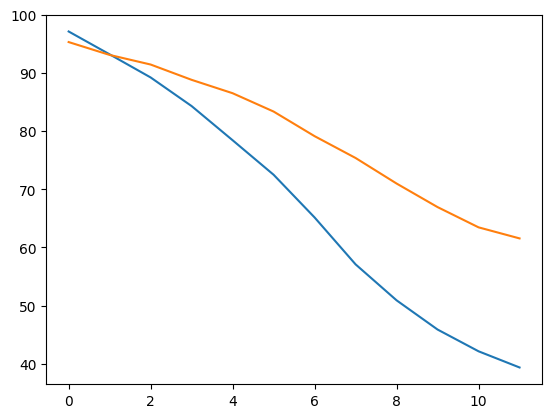

In [12]:
import matplotlib.pyplot as plt


bert_values = [95.3,
 93.09,
 91.44,
 88.81,
 86.51,
 83.36,
 79.13,
 75.38,
 70.99,
 66.94,
 63.46,
 61.56
]

plt.plot(electra_values)
plt.plot(bert_values)